In [1]:
import math
import numpy as np
import sys


In [2]:
import py4hw

In [3]:
from scipy.signal import kaiserord, lfilter, firwin, freqz

def bandpass_filter(Fs, start, stop, db, ntaps, ripple_db):
    nyq_rate = Fs/2
    width = stop - start
    N, beta = kaiserord(ripple_db, width)
    
    if (N > ntaps):
        print('WARNING: the kaiser window would require {} taps (more than the {} requested)'.format(N, ntaps))
    
    cutoff_hz = (start/nyq_rate, stop/nyq_rate)
    
    # Use firwin with a Kaiser window to create a lowpass FIR filter.
    taps = firwin(ntaps, cutoff_hz, window=('kaiser', beta), pass_zero='bandpass')
    return taps

In [4]:
class MultSignalByCoeff(py4hw.Logic):
    def __init__(self, parent, name, a, coeff, r):
        super().__init__(parent, name)
        
        self.addIn('a', a)
        self.addOut('r', r)
        
        w = a.getWidth()
        
        assert(w == r.getWidth())
        sa = self.wire('sa', w)
        
        sr = self.wire('sr', 2*w)
        k = self.wire('k', w)
        b = self.wire('b', w)
        
        py4hw.Constant(self, 'k', 1<<(w-1), k)
        
        py4hw.Constant(self, 'coeff', int((1<<(w-1)) * coeff), b)
        
        py4hw.SignedSub(self, 'sa', a, k, sa)
        py4hw.SignedMul(self, 'sr', sa, b, sr)
        
        py4hw.ShiftRightConstant(self, 'r', sr, w, r)

In [5]:
class BandpassFilter(py4hw.Logic):
    def __init__(self, parent, name, Fs, start, stop, db, ntaps, x, r):
        super().__init__(parent, name)
        
        self.addIn('x', x)
        self.addOut('r', r)
        
        w = x.getWidth()
        z = [x]
        last = x
        
        # create the registers for z-1
        for i in range(ntaps-1):
            nwire = 'z_{}'.format(i+1)
            wire = self.wire(nwire, w)
            z.append(wire)
            py4hw.Reg(self, nwire, d=last, q=wire)
            last = wire
            
        taps = bandpass_filter(Fs, start, stop, db, ntaps, db)
            
        for i in range(ntaps):
            pname = 'p{}'.format(i)
            p = self.wire(pname, w)
            
            MultSignalByCoeff(self, pname, z[i], taps[i], p)
            if (i == 0):
                last = p
            else:
                aname = 'a{}'.format(i)
                a = self.wire(aname, w)
                AddSignals(self, aname, p, last, a)
                last = a
                
        py4hw.Buf(self, 'buf', last, r)

In [6]:
class SinGenerator(py4hw.Logic):
    def __init__(self, parent, name, Fs, freq, amplitude, r):
        super().__init__(parent, name)
        
        self.Fs = Fs
        self.freq = freq
        self.amplitude = amplitude
        self.r = self.addOut('r', r)
        self.w = r.getWidth()
        
        self.phi_inc = 2*math.pi*freq*1/Fs
        self.phi = 0
        
    def clock(self):
        # @todo we should use a cordic approach
        bias = 1 << (self.w -1)
        self.r.prepare(int(bias+bias*amplitude*math.sin(self.phi)))
        self.phi += self.phi_inc
        
        if (self.phi > (math.pi*2)):
            self.phi -= (math.pi*2)        

In [7]:
class AddSignals(py4hw.Logic):
    def __init__(self, parent, name, a, b, r):
        super().__init__(parent, name)
        
        self.addIn('a', a)
        self.addIn('b', b)
        self.addOut('r', r)
        
        sa = self.wire('sa', a.getWidth())
        sb = self.wire('sb', b.getWidth())
        sr = self.wire('sr', r.getWidth())
        k = self.wire('k', r.getWidth())
        
        py4hw.Constant(self, 'k', 1<<15, k)
        
        py4hw.SignedSub(self, 'sa', a, k, sa)
        py4hw.SignedSub(self, 'sb', b, k, sb)
        
        py4hw.Add(self, 'sr', sa, sb, sr)
        py4hw.Add(self, 'r', sr, k, r)
        
        
        # c = self.wire('c', max(a.getWidth(), b.getWidth())+1)
        # k = self.wire('k', c.getWidth())
        # py4hw.Add(self, 'add', a, b, c)
        # py4hw.Constant(self, 'k', 1<<15, k)
        # py4hw.Sub(self, 'sub', c, k, r)
        

In [8]:
class StreamCapture(py4hw.Logic):
    def __init__(self, parent, name, x):
        super().__init__(parent, name)
        self.x = self.addIn('x', x)
        
        self.data = []
        
    def clock(self):
        self.data.append(self.x.get())

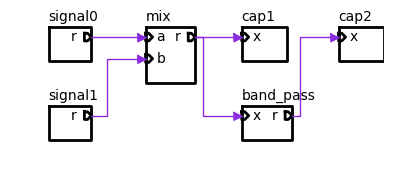

In [10]:
hw = py4hw.HWSystem()
hlp = py4hw.LogicHelper(hw)
dur = 0.01
Fs = 16000
freq0 = 440
freq1 = 880
amplitude = 0.5

x0 = hw.wire('x0', 16)
x1 = hw.wire('x1', 16)
m = hw.wire('m', 16)
x = hw.wire('x', 16)

SinGenerator(hw, 'signal0',Fs, freq0, amplitude, x0 )
SinGenerator(hw, 'signal1',Fs, freq1, amplitude, x1 )

AddSignals(hw, 'mix', x0, x1, m)

db = 60
ntaps = 16
start = 440-200
stop = 440+200

cap1 = StreamCapture(hw, 'cap1', m)

bp = BandpassFilter(hw, 'band_pass', Fs, start, stop, db, ntaps, m, x)

cap2 = StreamCapture(hw, 'cap2', x)

hw.getSimulator().clk(int(dur*Fs))

#sch = py4hw.Schematic(hw)
sch = py4hw.Schematic(hw)
sch.drawAll()
#plt.savefig('topFIR.png')

In [11]:
x = np.linspace(0, dur, int(Fs*dur), endpoint=False)
y = np.array(cap1.data)
filtered = np.array(cap2.data)
print(x.shape)

(160,)


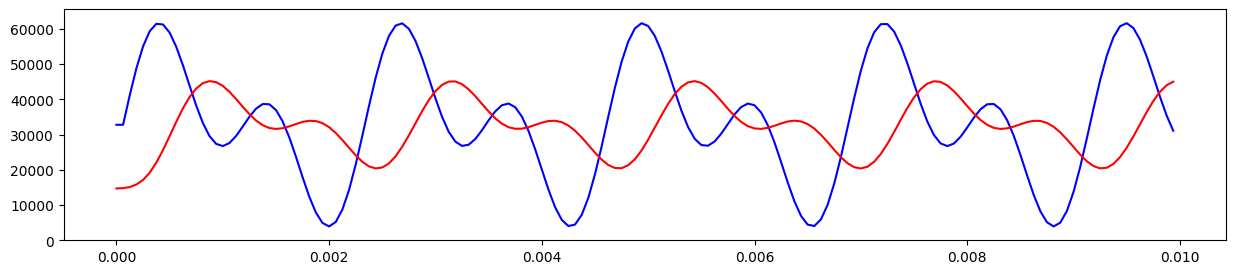

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,3))
plt.plot(x,y, color='blue')
plt.plot(x,filtered, color='red')
plt.ylim(0, 1<<16)
plt.savefig('filteredsignal.png')
plt.show()

In [14]:
if (False):
    rtlgen = py4hw.VerilogGenerator(bp)
    print(rtlgen.getVerilogForHierarchy( noInstanceNumberInTopEntity=True))